In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv, ive
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d
from scipy.integrate import quad, trapezoid

from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit, float64, int64, njit
import numba

In [2]:
@jit(nopython=True)
def simulate_RDM(threshold, lamda, mu, ndt, sigma=1, dt=0.001):
    x = np.zeros(mu.shape)
    rt = 0
    Stop = False
    while not Stop:
        x[0] += mu[0]*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
#         x[1] += mu[1]*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
#         x[2] += mu[2]*dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
        x[x<0] = 0
        
        bound = (threshold * np.exp(-lamda*rt))
        if (x>bound).sum() == 1:
            Stop = True
            choice = np.where(x>bound)[0]
        elif (x>bound).sum() > 1:
            x = np.zeros(x.shape)
            rt = 0 
    
    return ndt+rt, choice[0]

In [3]:
@jit(nopython=True)
def phi(x):
    n= 50
    a = 0
    b = x/np.sqrt(2)
    h=(b-a)/n
    k=0.0
    theta = a + h
    for i in range(1,n/2 + 1):
        k += 4*np.exp(-theta**2)
        theta += 2*h

    theta = a + 2*h
    for i in range(1,n/2):
        k += 2*np.exp(-theta**2)
        theta += 2*h
    f0 = 1
    fn = np.exp(-b**2)
    erf = 2*(h/3)*(f0+fn+k)/np.sqrt(np.pi)
    return 0.5*(1 + erf)

In [4]:
@jit(nopython=True)
def psi(threshold, lamda, t, z, tau, q, sigma=1):
    at = threshold * np.exp(-lamda*t)
    dat = -lamda*threshold*np.exp(-lamda*t)
    
    tt1 = 1/(2*sigma*np.sqrt(2*np.pi*(t - tau)))
    tt2 = dat - (at - z)/(t - tau)
    tt3 = np.exp(-(at - z - q * (t- tau))**2/(2 * sigma**2 * (t - tau)))
    term1 = tt1 * tt2 * tt3
    
    tt4 = dat - (at + z - 2*q*(t - tau))/(t - tau)
    tt5 = np.exp(- (2*q*z)/(sigma**2))
    tt6 = np.exp(- (at + z - q*(t - tau))**2/(2 * sigma**2 * (t - tau)))
    term2 = tt1 * tt4 * tt5 * tt6
    
    tt7 = (q*(dat + q))/(sigma**2)
    tt8 = np.exp((2*q*at)/(sigma**2))
    tt9 = phi(- (at + z + q*(t - tau))/(sigma*np.sqrt(t - tau)))
    term3 = tt7 * tt8 * tt9
    
    return term1 + term2 - term3

@jit(nopython=True)
def rdm_fpt(threshold, lamda, q, z, sigma=2, dt=0.1, T_max=2):
    g = np.zeros((int(T_max/dt)+2,))
    T = np.zeros((int(T_max/dt)+2,))
    
    g[1] = -2*psi(threshold, lamda, dt, z, 0, q, sigma)
    T[1] = dt
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(threshold, lamda, n*dt, z, 0, q, sigma)

        for j in range(1, n):            
            s += 2 * dt * g[j] * psi(threshold, lamda, n*dt, 
                                     threshold * np.exp(-lamda*j*dt), 
                                     j*dt, q, sigma)

        g[n] = s
        T[n] = n*dt
        
    return g, T

In [12]:
def RDM_likelihood(prms, RT, Choice):    
    ndt = prms[1]
#     mu = np.array([prms[3]], prms[4], prms[5]])
        
    T_max = max(RT)
    gg, TT = rdm_fpt(prms[0], 0, prms[2], 0, dt=0.02, T_max=T_max)
    pdf1 = interp1d(TT, gg)
#     cdf1 = lambda t: trapezoid(pdf1(np.linspace(0, t, 50)), np.linspace(0, t, 50))
    
#     gg, TT = rdm_fpt(prms[0], prms[1], prms[4], 0, dt=0.2, T_max=T_max)
#     pdf2 = interp1d(TT, gg)
#     cdf2 = lambda t: trapezoid(pdf2(np.linspace(0, t, 50)), np.linspace(0, t, 50))
    
#     gg, TT = rdm_fpt(prms[0], prms[1], prms[5], 0, dt=0.2, T_max=T_max)
#     pdf3 = interp1d(TT, gg)
#     cdf3 = lambda t: trapezoid(pdf3(np.linspace(0, t, 50)), np.linspace(0, t, 50))
        
    log_lik = 0
    for i in range(len(RT)):
        rt, ch = RT[i], Choice[i]
        if rt - ndt > 0.0001 and rt - ndt < T_max:
            density = pdf1(rt - ndt)
#             if ch == 0:
#                 density = pdf1(rt - ndt) * (1 - cdf2(rt - ndt)) * (1 - cdf3(rt - ndt))
#             elif ch == 1:
#                 density = pdf2(rt - ndt) * (1 - cdf1(rt - ndt)) * (1 - cdf3(rt - ndt))
#             elif ch == 2:
#                 density = pdf3(rt - ndt) * (1 - cdf1(rt - ndt)) * (1 - cdf2(rt - ndt))
            
            if 0.1**14 < density:
                log_lik += -np.log(density)
            else:
                log_lik += -np.log(0.1**14)
        else:
            log_lik += -np.log(0.1**14)
        
    return log_lik

In [13]:
recovery_dic = {'b0_true': [],
                'b0_estimate': [],
#                 'lambda_true': [],
#                 'lambda_estimate': [],
                'ndt_true': [],
                'ndt_estimate': [],
                'mu1_true': [],
                'mu1_estimate': []}#,
#                 'mu2_true': [],
#                 'mu2_estimate': [],
#                 'mu3_true': [],
#                 'mu3_estimate': []}

min_b0 = 2
max_b0 = 5

min_lambda = .1
max_lambda = 2

min_ndt = 0.1
max_ndt = 1

min_mu = 0
max_mu = 4
bounds = [(min_b0, max_b0), #(min_lambda, max_lambda), 
          (min_ndt, max_ndt), (min_mu, max_mu)]#, 
#          (min_mu, max_mu), (min_mu, max_mu)]

In [14]:
# RDM_likelihood([b0, lamb, mu[0], mu[1], mu[2], ndt], RT, CH)

In [15]:
for n in tqdm(range(5)):
    b0 = np.random.uniform(min_b0, max_b0)
    lamb = 0 #np.random.uniform(min_lambda, max_lambda)
    
    ndt = np.random.uniform(min_ndt, max_ndt)
    mu = np.array([np.random.uniform(min_mu, max_mu)])#, 
#                    np.random.uniform(min_mu, max_mu),
#                    np.random.uniform(min_mu, max_mu)])
    
    RT = []
    CH = []
    
    for i in range(500):
        rt, ch = simulate_RDM(b0, lamb, mu, ndt)
        RT.append(rt)
        CH.append(ch)
    
    min_ans = differential_evolution(RDM_likelihood,
                                     args=(RT, CH),
                                     bounds=bounds)
    
    min_ans = minimize(RDM_likelihood,
                       args=(RT, CH),
                       method='nelder-mead',
                       x0=min_ans.x,
                       bounds=bounds)
    
    if min_ans.success:
        recovery_dic['b0_true'].append(b0)
#         recovery_dic['lambda_true'].append(lamb)
        recovery_dic['ndt_true'].append(ndt)
        recovery_dic['mu1_true'].append(mu[0])
#         recovery_dic['mu2_true'].append(mu[1])
#         recovery_dic['mu3_true'].append(mu[2])

        recovery_dic['b0_estimate'].append(min_ans.x[0])
#         recovery_dic['lambda_estimate'].append(min_ans.x[1])
        recovery_dic['ndt_estimate'].append(min_ans.x[1])
        recovery_dic['mu1_estimate'].append(min_ans.x[2])
#         recovery_dic['mu2_estimate'].append(min_ans.x[4])
#         recovery_dic['mu3_estimate'].append(min_ans.x[5])

 60%|███████████████████████████                  | 3/5 [04:46<03:10, 95.45s/it]


SystemError: CPUDispatcher(<function rdm_fpt at 0x145d81870>) returned a result with an exception set

In [16]:
recovery_df = pd.DataFrame(recovery_dic)

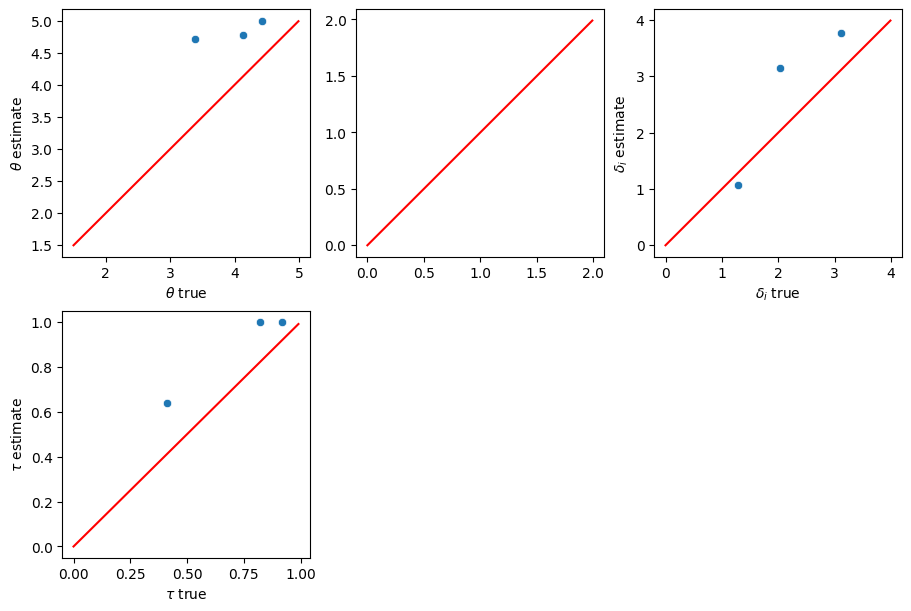

In [17]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 5, 0.01), np.arange(1.5, 5, 0.01), c='red')
sns.scatterplot(x='b0_true', y='b0_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
# sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
# plt.xlabel(r'$\lambda$ true')
# plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(0, 4, 0.01), np.arange(0, 4, 0.01), c='red')
sns.scatterplot(x='mu1_true', y='mu1_estimate', data=recovery_df);
# sns.scatterplot(x='mu2_true', y='mu2_estimate', data=recovery_df, c='tab:blue');
plt.xlabel(r'$\delta_i$ true')
plt.ylabel(r'$\delta_i$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate');

In [ ]:
print(recovery_df.shape)
recovery_df.corr()

In [ ]:
recovery_df.to_csv('Exponential_rec.csv')